In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 112.0 MB/s eta 0:00:00
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=d79afe98c741fdbcf53eac3894a6422142386a74c00ca2

In [ ]:
import torch


print("Runtime restarted, checking GPU...")

!nvidia-smi

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.cuda.empty_cache()
print(f"Before anything: Allocated: {torch.cuda.memory_allocated(device)/1024**3:.2f} GB, Cached: {torch.cuda.memory_reserved(device)/1024**3:.2f} GB")

Runtime restarted, checking GPU...
Tue Apr 22 09:27:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             48W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+------------

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from efficientnet_pytorch import EfficientNet
from transformers import AutoModel, AutoTokenizer
import json
import os
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
image_folder = "/content/drive/MyDrive/GP2/6_After_2-Image_Augmentation/Images_After_2-Image_Augmentation"
json_file = "/content/drive/MyDrive/GP2/6_After_2-Image_Augmentation/Image_2_Augmented.json"


Mounted at /content/drive


In [ ]:
import json
import os
from sklearn.model_selection import train_test_split

with open(json_file, 'r') as f:
    data = json.load(f)

label_mapping = {
    "Congenital & Genetic": 0,
    "Trauma & Physical Injuries": 1,
    "Vascular & Circulatory": 2,
    "Infections": 3,
    "Neoplasm - Benign & Sarcoma": 4,
    "Neoplasm - Carcinoma": 5,
    "Neoplasm - Other Malignant": 6,
    "Inflammatory & Autoimmune": 7,
    "Metabolic & Endocrine": 8,
    "Cysts & Degenerative Conditions": 9,
    "Obstruction & Structural Abnormalities": 10,
    "Miscellaneous Conditions": 11
}

patient_data = []

for entry in data:
    image_files = entry.get('MRI', []) + entry.get('TAC', [])
    image_paths = [os.path.join(image_folder, f"{img}.png") for img in image_files]

    case_text = (
        f"Title: {entry['Case']['Title']}\n"
        f"History: {entry['Case'].get('History', '')}\n"
        f"Exam: {entry['Case'].get('Exam', '')}\n"
        f"Differential Diagnosis: {entry['Case'].get('Differential Diagnosis', '')}"
    )

    location = entry.get("Location", "Unknown")

    label = entry['Class/Label']
    numeric_label = label_mapping.get(label, -1)

    patient_data.append({
        "images": image_paths,
        "text": case_text,
        "label": numeric_label,
        "location": location
    })

train_data, test_data = train_test_split(patient_data, test_size=0.2, random_state=42)

print(f"Training size: {len(train_data)}, Testing size: {len(test_data)}")
print(f"First entry: {train_data[0]}")
print(f"Label mapping: {label_mapping}")


Training size: 5678, Testing size: 1420
First entry: {'images': ['/content/drive/MyDrive/GP2/6_After_2-Image_Augmentation/Images_After_2-Image_Augmentation/MPX1139_synpic18560_RR.png', '/content/drive/MyDrive/GP2/6_After_2-Image_Augmentation/Images_After_2-Image_Augmentation/MPX1139_synpic18561_RR.png'], 'text': 'Title: Incidental Malrotation and Acute Appendicitis\nHistory: 67 year old male presents to the ED with acute onset of lower abdominal pain associated with fever, nausea and vomiting.\nExam: Rebound tenderness with palpation of abdomen and associated guarding. Fever 103 F WBC 17,000\nDifferential Diagnosis: Malrotation Diverticulitis Acute Appendicitis Mesenteric Adenitis Infectious Enteritis Atypical cholecystitis', 'label': 0, 'location': 'Gastrointestinal'}
Label mapping: {'Congenital & Genetic': 0, 'Trauma & Physical Injuries': 1, 'Vascular & Circulatory': 2, 'Infections': 3, 'Neoplasm - Benign & Sarcoma': 4, 'Neoplasm - Carcinoma': 5, 'Neoplasm - Other Malignant': 6, 'Inf

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

class MultimodalDataset(Dataset):
    def __init__(self, data, tokenizer, transform):
        self.data = data
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]

        images = []
        for img_path in entry['images'][:1]:
            if os.path.exists(img_path):
                try:
                    image = Image.open(img_path).convert("RGB")
                    image = self.transform(image)
                    images.append(image)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}. Skipping.")
            else:
                print(f"Warning: Missing image {img_path}, skipping.")

        if len(images) > 1:
            images = torch.stack(images)
            images = torch.mean(images, dim=0)
        elif len(images) == 1:
            images = images[0]
        else:
            print(f"Warning: No valid images for entry {idx}. Using blank image.")
            images = torch.zeros((3, 224, 224))

        tokens = self.tokenizer(
            entry["text"], padding="max_length", truncation=True, max_length=32, return_tensors="pt"
        )

        label = torch.tensor(entry["label"], dtype=torch.long)

        return images, tokens["input_ids"].squeeze(0), tokens["attention_mask"].squeeze(0), label


In [ ]:
import torch

!nvidia-smi

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.cuda.empty_cache()
print(f"Before anything: Allocated: {torch.cuda.memory_allocated(device)/1024**3:.2f} GB, Cached: {torch.cuda.memory_reserved(device)/1024**3:.2f} GB")

Tue Apr 22 09:28:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             48W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
class ImageFeatureExtractor(nn.Module):
    def __init__(self, model_name="efficientnet-b0"):
        super().__init__()
        self.model = EfficientNet.from_pretrained(model_name)
        self.model._fc = nn.Identity()

    def forward(self, x):
        return self.model(x)

text_model_name = "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext"
tokenizer = AutoTokenizer.from_pretrained(text_model_name)
text_model = AutoModel.from_pretrained(text_model_name)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
text_model.resize_token_embeddings(len(tokenizer))

image_model = ImageFeatureExtractor().to(device)
text_model = text_model.to(device)

image_classifier = nn.Linear(1280, 12).to(device)
text_classifier = nn.Linear(768, 12).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

  0%|          | 0.00/20.4M [00:00<?, ?B/s]
100%|██████████| 20.4M/20.4M [00:00<00:00, 126MB/s] 


Loaded pretrained weights for efficientnet-b0


In [ ]:
image_model = ImageFeatureExtractor().to(device)
torch.cuda.empty_cache()
print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(device)/1024**3:.2f} GB")
print(f"GPU Memory Cached: {torch.cuda.memory_reserved(device)/1024**3:.2f} GB")


text_model.resize_token_embeddings(len(tokenizer))

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = MultimodalDataset(data=train_data, tokenizer=tokenizer, transform=transform)
test_dataset = MultimodalDataset(data=test_data, tokenizer=tokenizer, transform=transform)


train_dataloader = DataLoader(
    train_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True
)

test_dataloader = DataLoader(
    test_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True
)


dataset = MultimodalDataset(patient_data, tokenizer, transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


optimizer = torch.optim.Adam(
    list(text_model.parameters()) + list(image_model.parameters()) +
    list(text_classifier.parameters()) + list(image_classifier.parameters()),
    lr=1e-4
)
criterion = nn.CrossEntropyLoss()



Loaded pretrained weights for efficientnet-b0
GPU Memory Allocated: 0.44 GB
GPU Memory Cached: 0.48 GB


In [ ]:
torch.cuda.empty_cache()

print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(device)/1024**3:.2f} GB")
print(f"GPU Memory Cached: {torch.cuda.memory_reserved(device)/1024**3:.2f} GB")

GPU Memory Allocated: 0.42 GB
GPU Memory Cached: 0.48 GB


In [ ]:
import os
file_path = "/content/drive/MyDrive/GP2/After_4-Image_Augmentation/Images_After_4-Image_Augmentation/MPX1309_synpic15871_aug_1_RR.png"

if os.path.exists(file_path):
    print("✅ File exists!")
else:
    print("❌ File is missing!")


❌ File is missing!


In [ ]:
import os

checkpoint_dir = "/content/drive/MyDrive/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
torch.cuda.empty_cache()

epochs = 5
torch.cuda.empty_cache()

from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler()
for epoch in range(epochs):
    image_model.train()
    image_classifier.train()

    running_loss = 0.0
    for batch_idx,(images, input_ids, attention_masks, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():
            image_feats = image_model(images)

            image_logits = image_classifier(image_feats)

            loss = criterion(image_logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()

        print(f"Epoch {epoch+1}, Batch {batch_idx+1}/{len(train_dataloader)}, Loss: {loss.item():.4f}")



    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_dataloader):.4f}")

print(f"Model saved for epoch {epoch+1}")


<ipython-input-12-809009835fcc>:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-12-809009835fcc>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1, Batch 1/710, Loss: 2.4602
Epoch 1, Batch 2/710, Loss: 2.4685
Epoch 1, Batch 3/710, Loss: 2.6160
Epoch 1, Batch 4/710, Loss: 2.4944
Epoch 1, Batch 5/710, Loss: 2.4929
Epoch 1, Batch 6/710, Loss: 2.4220
Epoch 1, Batch 7/710, Loss: 2.5859
Epoch 1, Batch 8/710, Loss: 2.3667
Epoch 1, Batch 9/710, Loss: 2.4521
Epoch 1, Batch 10/710, Loss: 2.6172
Epoch 1, Batch 11/710, Loss: 2.4932
Epoch 1, Batch 12/710, Loss: 2.6072
Epoch 1, Batch 13/710, Loss: 2.5598
Epoch 1, Batch 14/710, Loss: 2.3997
Epoch 1, Batch 15/710, Loss: 2.5029
Epoch 1, Batch 16/710, Loss: 2.4050
Epoch 1, Batch 17/710, Loss: 2.4519
Epoch 1, Batch 18/710, Loss: 2.4431
Epoch 1, Batch 19/710, Loss: 2.3395
Epoch 1, Batch 20/710, Loss: 2.4895
Epoch 1, Batch 21/710, Loss: 2.4480
Epoch 1, Batch 22/710, Loss: 2.5037
Epoch 1, Batch 23/710, Loss: 2.4174
Epoch 1, Batch 24/710, Loss: 2.4382
Epoch 1, Batch 25/710, Loss: 2.5493
Epoch 1, Batch 26/710, Loss: 2.5320
Epoch 1, Batch 27/710, Loss: 2.3961
Epoch 1, Batch 28/710, Loss: 2.4985
E

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

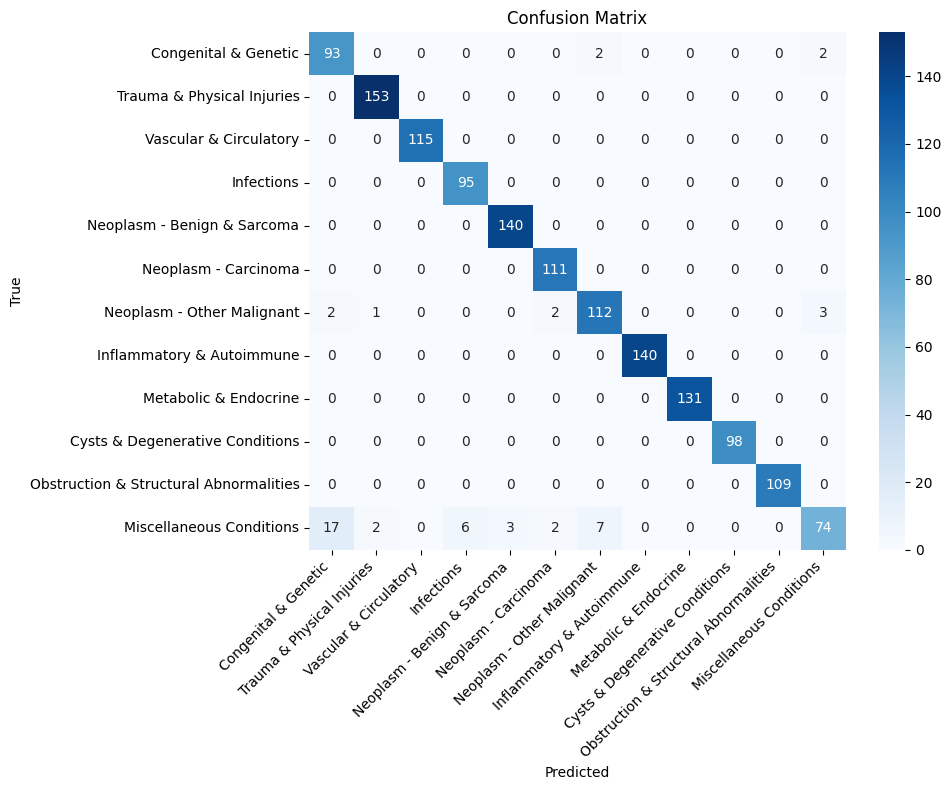

In [ ]:
image_model.eval()
image_classifier.eval()

all_labels, all_preds, all_probs = [], [], []
i=0
with torch.no_grad():
    for images, input_ids, attention_masks, labels in test_dataloader:
        images = images.to(device)
        image_feats = image_model(images)

        image_logits = image_classifier(image_feats)

        probs = torch.softmax(image_logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_labels.extend(labels.numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        print(i)
        i+=1

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

conf_matrix = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()


Classification Report:
                                        precision    recall  f1-score   support

                  Congenital & Genetic       0.83      0.96      0.89        97
            Trauma & Physical Injuries       0.98      1.00      0.99       153
                Vascular & Circulatory       1.00      1.00      1.00       115
                            Infections       0.94      1.00      0.97        95
           Neoplasm - Benign & Sarcoma       0.98      1.00      0.99       140
                  Neoplasm - Carcinoma       0.97      1.00      0.98       111
            Neoplasm - Other Malignant       0.93      0.93      0.93       120
             Inflammatory & Autoimmune       1.00      1.00      1.00       140
                 Metabolic & Endocrine       1.00      1.00      1.00       131
       Cysts & Degenerative Conditions       1.00      1.00      1.00        98
Obstruction & Structural Abnormalities       1.00      1.00      1.00       109
              M

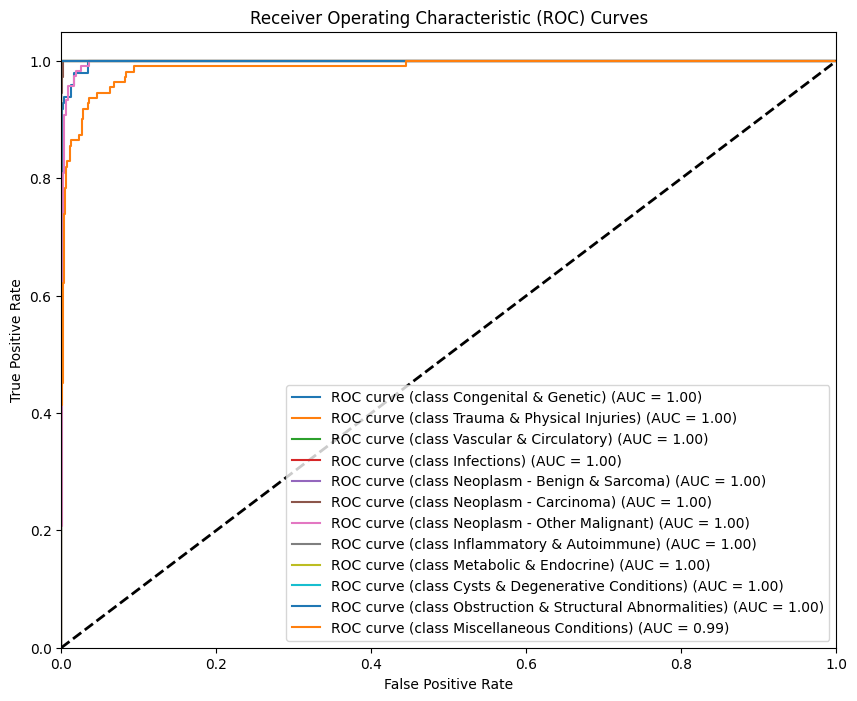


AUC-ROC for each class:
Class Congenital & Genetic: 0.9984
Class Trauma & Physical Injuries: 1.0000
Class Vascular & Circulatory: 1.0000
Class Infections: 1.0000
Class Neoplasm - Benign & Sarcoma: 1.0000
Class Neoplasm - Carcinoma: 0.9999
Class Neoplasm - Other Malignant: 0.9976
Class Inflammatory & Autoimmune: 1.0000
Class Metabolic & Endocrine: 1.0000
Class Cysts & Degenerative Conditions: 1.0000
Class Obstruction & Structural Abnormalities: 1.0000
Class Miscellaneous Conditions: 0.9882


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import numpy as np

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=[str(key) for key in label_mapping.keys()]))

from sklearn.preprocessing import label_binarize
num_classes = len(label_mapping)
y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))
y_probs = np.array(all_probs)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

macro_roc_auc = np.mean(list(roc_auc.values()))
print(f"\nMacro-Average AUC-ROC: {macro_roc_auc:.4f}")

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {list(label_mapping.keys())[i]}) (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

print("\nAUC-ROC for each class:")
for i, class_name in enumerate(label_mapping.keys()):
    print(f"Class {class_name}: {roc_auc[i]:.4f}")

In [ ]:
image_model.eval()
text_model.eval()
image_classifier.eval()
text_classifier.eval()

train_labels, train_preds = [], []

with torch.no_grad():
    for images, input_ids, attention_masks, labels in train_dataloader:
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        image_feats = image_model(images)
        text_feats = text_model(input_ids=input_ids, attention_mask=attention_masks).last_hidden_state[:, 0, :]

        image_logits = image_classifier(image_feats)
        text_logits = text_classifier(text_feats)

        fused_logits = (image_logits + text_logits) / 2
        probs = torch.softmax(fused_logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        train_labels.extend(labels.cpu().numpy())
        train_preds.extend(preds.cpu().numpy())

train_accuracy = accuracy_score(train_labels, train_preds)
print(f"\n✅ Training Accuracy: {train_accuracy:.4f} ({train_accuracy * 100:.2f}%)")


✅ Training Accuracy: 0.9959 (99.59%)
